# Train notebook

## Grocery products recognition

Hello and welcome to this notebook. 

This notebook trains a YOLOv2 algorithm in order to localize the grocery products in the supermarket shell.

The following dataset is used to train this CNN:
[Grocery Store dataset](https://www.amazon.de/clouddrive/share/J3OaZMNnhBpKG28mAfs5CqTgreQxFCY8uENGaIk7H3s?_encoding=UTF8&mgh=1&ref_=cd_ph_share_link_copy).

This dataset was annotated in the work by [George, Marian and Floerkemeier](http://vision.disi.unibo.it/index.php?option=com_content&view=article&id=111&catid=78). (There is only 74 images annotated.)

The Yolo (You Only Look Once) algorithm is presented in the following papers:
* Redmon et al., 2016 (https://arxiv.org/abs/1506.02640) 
* Redmon and Farhadi, 2016 (https://arxiv.org/abs/1612.08242).

The yolo algorithm was originally tested in [Darknet]( https://pjreddie.com/darknet). This algorithm has been implemented in python for several machine-learning frameworks. This work is based in the [YAD2K]( https://github.com/allanzelener/YAD2K) implementation for Keras and Tensorflow.

#### This notebook will guide you in order to train your own network


## Import some libraries

In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import scipy.io
import scipy.misc
import numpy as np
import pandas as pd
import PIL
import wget
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from keras.backend.tensorflow_backend import set_session
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from yolo_utils import read_images, read_boxes, read_classes, read_anchors, generate_colors, draw_boxes_simple, get_detector_mask

from train_yolo_utils import create_model, draw
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body, preprocess_true_boxes,yolo_eval

%matplotlib inline

Using TensorFlow backend.


This lines prevent some errors in the training phase

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.7
set_session(tf.Session(config=config))

The data format for this work (different from YAD2K), is based in four different txt files
* images_path: This txt file contains a list of the images paths (ex: Grocery_products/Testing/store1/images/14.jpg)
* boxes_path: This txt file contains a list of the txt paths (ex: yolo_annotations/s1_14.txt) those files contain the box corners in YOLO style
* classes_path: Txt file with the list of different classes
* anchors_path: Txt file with the anchors info

(For further information the data formatting is made in the notebook "Data_preprocess_for_products_recognition")

In [3]:
# if you want to train all the models set =True
train = True

images_path  = 'model_data/images_path.txt'
boxes_path   = 'model_data/boxes_path.txt'
classes_path = 'model_data/groceries_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'

In [4]:
# read and preprocess the images
processed_images, images = read_images(images_path)

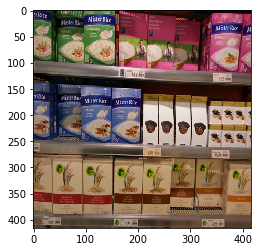

In [5]:
# Show one of the preprocessed images
imshow(processed_images[0])

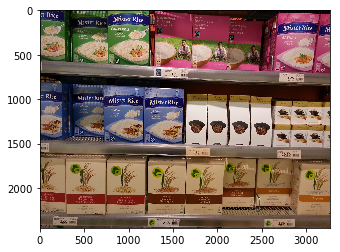

In [6]:
# Show one of the original images
imshow(images[0])

In [7]:
# read and preprocess the boxes (add padding)
boxes = read_boxes(boxes_path)

In [8]:
boxes.shape

(74, 29, 5)

In [9]:
# read classes
class_names = read_classes(classes_path)

In [10]:
class_names

['product', 'other']

In [11]:
# read anchors
anchors = read_anchors(anchors_path)

In [12]:
anchors

array([[ 0.57273 ,  0.677385],
       [ 1.87446 ,  2.06253 ],
       [ 3.33843 ,  5.47434 ],
       [ 7.88282 ,  3.52778 ],
       [ 9.77052 ,  9.16828 ]])

(3264, 2448)


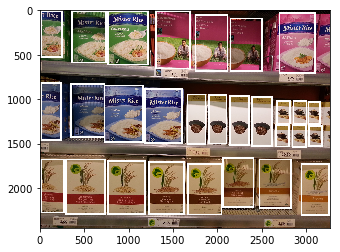

In [13]:
# Draw one image with the annotated boxes
draw_boxes_simple(images[0],boxes[0])

In [14]:
# Precompute detectors_mask and matching_true_boxes for training.
detectors_mask, matching_true_boxes = get_detector_mask(boxes, anchors)

There are different versions of YOLO with different structures as shown here https://pjreddie.com/darknet/yolo/.

Because of my computer power, I had some difficulties training a YOLOv2 with more than 50 000 000 parameters. Therefore, this work modified the base model in order to train a "tiny-yolo".

This work used the tiny-yolo trained with the "VOC 2007+2012". If you want to use a different model, you should modify the "create_model" function (specially the "tiny_yolo_body" function in that fuction)


In [15]:
# download the tiny-yolo-voc structure, weights. Create h5 file to create the base model for keras
my_h5 = "model_data/tiny-yolo-voc.h5"
my_cfg = "model_data/tiny-yolo-voc.cfg"
my_weights = "model_data/tiny-yolo-voc.weights"

if not os.path.isfile(my_h5) :
    if not os.path.isfile(my_cfg) :
        wget.download('https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/tiny-yolo-voc.cfg', out='model_data')
    if not os.path.isfile(my_weights) :
        wget.download('https://pjreddie.com/media/files/tiny-yolo-voc.weights', out='model_data')
        
    %run yad2k.py model_data/tiny-yolo-voc.cfg model_data/tiny-yolo-voc.weights model_data/tiny-yolo-voc.h5

In [16]:
model_body, model = create_model(anchors, class_names)

tiny-yolo-voc


In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 416, 416, 16) 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 416, 416, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 416, 416, 16) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

# Training

The training is made in 3 stages. As follows

The first one train a part of the CNN, and the next two stages train all the network.

In [18]:
if train:
    validation_split=0.1
    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    logging = TensorBoard()
    checkpoint = ModelCheckpoint("model_data/trained_stage_3_best.h5", monitor='val_loss',
                                 save_weights_only=True, save_best_only=True)
    early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=1, mode='auto')

In [19]:
if train:
    model.fit([processed_images, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(processed_images)),
              validation_split=validation_split,
              batch_size=16,
              epochs=5,
              callbacks=[logging])

    model.save_weights('model_data/trained_stage_1.h5')

Train on 66 samples, validate on 8 samples
Epoch 1/5
66/66 [==============================] - 3s 40ms/step - loss: 1910.7644 - val_loss: 544.8329
Epoch 2/5
66/66 [==============================] - 1s 20ms/step - loss: 798.9265 - val_loss: 397.6233
Epoch 3/5
66/66 [==============================] - 1s 20ms/step - loss: 577.5742 - val_loss: 384.4141
Epoch 4/5
66/66 [==============================] - 1s 19ms/step - loss: 547.3147 - val_loss: 383.1917
Epoch 5/5
66/66 [==============================] - 1s 20ms/step - loss: 534.2831 - val_loss: 379.5376


In [20]:
if train:
    model_body, model = create_model(anchors, class_names, load_pretrained=False, freeze_body=False)


tiny-yolo-voc


In [21]:
if train:
    model.load_weights('model_data/trained_stage_1.h5')

    model.compile(
        optimizer='adam', loss={
            'yolo_loss': lambda y_true, y_pred: y_pred
        })  # This is a hack to use the custom loss function in the last layer.


    model.fit([processed_images, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(processed_images)),
              validation_split=0.1,
              batch_size=8,
              epochs=60,
              callbacks=[logging])

    model.save_weights('model_data/trained_stage_2.h5')

Train on 66 samples, validate on 8 samples
Epoch 1/60
66/66 [==============================] - 5s 77ms/step - loss: 1025.7235 - val_loss: 20200.6641
Epoch 2/60
66/66 [==============================] - 3s 39ms/step - loss: 263.2653 - val_loss: 35390.5586
Epoch 3/60
66/66 [==============================] - 3s 40ms/step - loss: 187.7033 - val_loss: 15864.7363
Epoch 4/60
66/66 [==============================] - 3s 39ms/step - loss: 153.0644 - val_loss: 4562.7451
Epoch 5/60
66/66 [==============================] - 3s 39ms/step - loss: 131.8015 - val_loss: 2859.4897
Epoch 6/60
66/66 [==============================] - 3s 40ms/step - loss: 111.4587 - val_loss: 1786.1335
Epoch 7/60
66/66 [==============================] - 3s 39ms/step - loss: 96.0868 - val_loss: 1392.3744
Epoch 8/60
66/66 [==============================] - 3s 39ms/step - loss: 85.4246 - val_loss: 1210.5284
Epoch 9/60
66/66 [==============================] - 3s 40ms/step - loss: 69.6157 - val_loss: 921.3133
Epoch 10/60
66/66 [==

In [22]:
if train:
    model.fit([processed_images, boxes, detectors_mask, matching_true_boxes],
              np.zeros(len(processed_images)),
              validation_split=0.1,
              batch_size=8,
              epochs=300,
              callbacks=[logging, checkpoint, early_stopping])

    model.save_weights('model_data/trained_stage_3.h5')

Train on 66 samples, validate on 8 samples
Epoch 1/300
66/66 [==============================] - 3s 44ms/step - loss: 1.8088 - val_loss: 273.2325
Epoch 2/300
66/66 [==============================] - 3s 40ms/step - loss: 1.8401 - val_loss: 274.2824
Epoch 3/300
66/66 [==============================] - 3s 40ms/step - loss: 1.7232 - val_loss: 274.5042
Epoch 4/300
66/66 [==============================] - 3s 41ms/step - loss: 1.8985 - val_loss: 275.2284
Epoch 5/300
66/66 [==============================] - 3s 39ms/step - loss: 1.7560 - val_loss: 275.5955
Epoch 6/300
66/66 [==============================] - 3s 39ms/step - loss: 1.5687 - val_loss: 276.0382
Epoch 7/300
66/66 [==============================] - 3s 39ms/step - loss: 1.7720 - val_loss: 276.3514
Epoch 8/300
66/66 [==============================] - 3s 39ms/step - loss: 1.6181 - val_loss: 276.2424
Epoch 9/300
66/66 [==============================] - 3s 39ms/step - loss: 1.7681 - val_loss: 276.3855
Epoch 10/300
66/66 [===================

66/66 [==============================] - 3s 39ms/step - loss: 1.3367 - val_loss: 275.0846
Epoch 81/300
66/66 [==============================] - 3s 39ms/step - loss: 1.3594 - val_loss: 273.1796
Epoch 82/300
66/66 [==============================] - 3s 43ms/step - loss: 1.3775 - val_loss: 270.6731
Epoch 83/300
66/66 [==============================] - 3s 44ms/step - loss: 1.3328 - val_loss: 269.1520
Epoch 84/300
66/66 [==============================] - 3s 40ms/step - loss: 1.3443 - val_loss: 269.9551
Epoch 85/300
66/66 [==============================] - 3s 39ms/step - loss: 1.3365 - val_loss: 271.8842
Epoch 86/300
66/66 [==============================] - 3s 39ms/step - loss: 1.3277 - val_loss: 271.7432
Epoch 87/300
66/66 [==============================] - 3s 39ms/step - loss: 1.3849 - val_loss: 274.4142
Epoch 88/300
66/66 [==============================] - 3s 39ms/step - loss: 1.4446 - val_loss: 273.8997
Epoch 89/300
66/66 [==============================] - 3s 39ms/step - loss: 1.4410 - va

In [23]:
if train:
    model.save('model_data/Products_recognition_model.h5')
    model_body.save('model_data/Products_recognition_body.h5')

Because some problems with windowns 10, the test images are computed with the CPU

In [24]:
config = tf.ConfigProto(device_count = {'GPU': 0})
set_session(tf.Session(config=config))

This fuction test the CNN with the test images form the data set.

In [25]:
draw(model_body,
    class_names,
    anchors,
    processed_images,
    image_set='val', # assumes training/validation split is 0.9
    weights_name='model_data/trained_stage_3_best.h5',
    out_path="train_out",
    save_all=False)

(8, 1, 416, 416, 3)
Found 15 boxes for image.
[[ 323.16455078    5.14372158  417.23272705  107.04837799]
 [ 320.26220703  341.10360718  405.55438232  410.53686523]
 [ 318.33251953  106.10667419  401.92089844  179.26661682]
 [ 327.18527222  267.81256104  415.38998413  345.08724976]
 [ 163.19415283  254.19581604  273.39105225  330.04171753]
 [ 335.01849365  178.55529785  413.24542236  254.76040649]
 [ 169.50923157  172.0569458   268.58978271  253.67134094]
 [ 163.18389893  357.73223877  276.44717407  455.44598389]
 [ 169.42909241   78.24763489  269.69775391  167.39123535]
 [  20.24704933  186.86535645  102.24362183  250.32911682]
 [  21.98499298  364.56619263  125.91383362  424.38269043]
 [ 168.7714386     2.8770349   271.34008789   69.32707977]
 [  20.09314346   91.985672    101.94657135  154.59701538]
 [  -9.52949524  273.70782471   40.08110809  348.746521  ]
 [  33.08687592  276.06625366  113.43408966  340.5512085 ]]
(8, 1, 416, 416, 3)
product 1.00 (5, 323) (107, 416)
product 0.99 (3

# To see this images go to "train_out"